In [2]:
import json
import os
from dotenv import load_dotenv
from pathlib import Path

dotenv_path = Path("../../.env")
if dotenv_path.exists():
    print("Loaded .env file!")
    load_dotenv(str(dotenv_path))


data = json.load(open(Path(os.environ["PROJECT_HOME_DIR"]) / "data/corrected_train_v1.json"))

Loaded .env file!


In [16]:
import pandas as pd

ref_df = pd.read_parquet(Path(os.environ["PROJECT_HOME_DIR"]) / "data/corrected_train_v1.pq")

fp_df = pd.read_parquet(Path(os.environ["PROJECT_HOME_DIR"]) / "data/fp_names.pq")
fp_df["doc-tok"] = fp_df["document"].astype(str) + "-" + fp_df["token"].astype(str)
ref_df["doc-tok"] = ref_df["document"].astype(str) + "-" + ref_df["token"].astype(str)

ref_df = ref_df[ref_df["label"].str.contains("NAME_STU") | ref_df["doc-tok"].isin(fp_df["doc-tok"])]


ref_df

,document,token,token_text,label,doc-tok
9,7,9,Nathalie,B-NAME_STUDENT,7-9
10,7,10,Sylla,I-NAME_STUDENT,7-10
482,7,482,Nathalie,B-NAME_STUDENT,7-482
483,7,483,Sylla,I-NAME_STUDENT,7-483
741,7,741,Nathalie,B-NAME_STUDENT,7-741
...,...,...,...,...,...
4835111,22206,884,Madelon,O,22206-884
4835130,22206,903,René,O,22206-903
4852319,22262,224,Gretel,O,22262-224
4852387,22262,292,Steve,O,22262-292


In [10]:
from transformers import AutoTokenizer

tok = AutoTokenizer.from_pretrained("microsoft/phi-2")

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
from datasets import Dataset

ds = Dataset.from_dict({"text": [x["full_text"] for x in data]})

ds = ds.map(lambda x: tok(x["text"], padding=False, truncation=False), batched=True, num_proc=4)

Map (num_proc=4):   0%|          | 0/6807 [00:00<?, ? examples/s]

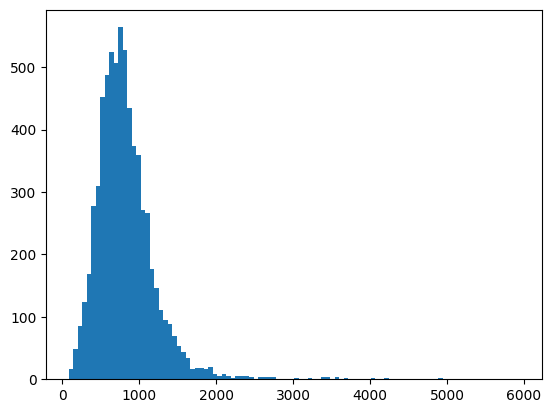

In [11]:
# histogram of lengths

import matplotlib.pyplot as plt

lengths = [len(x) for x in ds["input_ids"]]

plt.hist(lengths, bins=100);

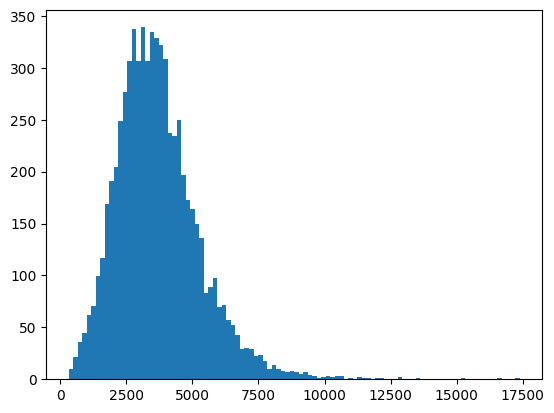

In [72]:
lengths = [len(x) for x in ds["text"]]

plt.hist(lengths, bins=100);

In [84]:
def create_snippet(idx, tokens, whitespace, num_tokens_before=400, num_tokens_after=400, start_delimiter="", end_delimiter=""):

    max_idx  = len(tokens)

    before_tokens = tokens[max(0, idx-num_tokens_before):idx]

    before_text = ""
    for b, bws in zip(before_tokens, whitespace[max(0, idx-num_tokens_before):idx]):
        before_text += b
        if bws:
            before_text += " "

    if idx+1 >= max_idx:
        after = []
    else:
        after = tokens[idx+1:idx+num_tokens_after]

        after_text = ""
        for a, aws in zip(after, whitespace[idx+1:idx+num_tokens_after]):
            after_text += a
            if aws:
                after_text += " "

    text = before_text + start_delimiter + tokens[idx] + end_delimiter

    if whitespace[idx]:
        text += " "
    
    text += after_text

    return text

In [89]:
texts = []
docs = []
labels = []
names = []



for d in ref_df.document.unique():
    temp = ref_df[ref_df["document"] == d].drop_duplicates("token_text")

    doc = [x for x in data if x["document"] == d][0]

    tokens = doc["tokens"]
    
    for token_text, token, label in temp[["token_text", 'token', 'label']].values:

        text = create_snippet(token, tokens, doc["trailing_whitespace"])

        texts.append(text)
        docs.append(d)
        names.append(token_text)
        if "NAME_STU" not in label:
            label = "O"
        labels.append(label)


name_df = pd.DataFrame({"text": texts, "document": docs, "name": names, "label": labels})

name_df

,text,document,name,label
0,Design Thinking for innovation reflexion-Avril...,7,Nathalie,B-NAME_STUDENT
1,Design Thinking for innovation reflexion-Avril...,7,Sylla,I-NAME_STUDENT
2,Diego Estrada\n\nDesign Thinking Assignment\n\...,10,Diego,B-NAME_STUDENT
3,Diego Estrada\n\nDesign Thinking Assignment\n\...,10,Estrada,I-NAME_STUDENT
4,Reporting process\n\nby Gilberto Gamboa\n\nCha...,16,Gilberto,B-NAME_STUDENT
...,...,...,...,...
2408,Design Thinking for Innovation – Reflection\n\...,22206,Madelon,O
2409,Design Thinking for Innovation – Reflection\n\...,22206,René,O
2410,The best way to get physical schooling experie...,22262,Gretel,O
2411,The best way to get physical schooling experie...,22262,Steve,O


In [90]:
name_df.label.value_counts()

B-NAME_STUDENT    948
I-NAME_STUDENT    851
O                 614
Name: label, dtype: int64

In [92]:
614*.93

571.02

In [93]:
948+851

1799

In [91]:
name_df.to_parquet("llm-names-v1.pq")

In [55]:
names = []


# BUGGY

for d in ref_df.document.unique():
    temp = ref_df[ref_df["document"] == d]

    temp_names = {}
    temp_name = ""
    prev = -2
    prev_label = ""
    for t, tt, l in temp[["token", "token_text", "label"]].sort_values("token").values:
        if len(tt) == 1 or len(tt) > 20:
            continue

        if l.startswith("B"):
            if temp_name:
                if temp_name not in temp_names:
                    temp_names[temp_name] = []
                temp_names[temp_name].append(t)
            temp_name = tt
        elif l.startswith("I"):
            temp_name += " " + tt
        else:
            if prev + 1 == t:
                if l == "O" and prev_label.startswith("I"):
                    if temp_name not in temp_names:
                        temp_names[temp_name] = []
                    temp_names[temp_name].append(t)
                    print(d, tt)
                    temp_name = t
                else:
                    temp_name += " " + tt
            else:
                if temp_name:
                    if temp_name not in temp_names:
                        temp_names[temp_name] = []
                    temp_names[temp_name].append(t)
                temp_name = tt 

        prev = t
        prev_label = l
    
    if temp_name:
        if temp_name not in temp_names:
            temp_names[temp_name] = []
        temp_names[temp_name].append(t)

    names.append((d, temp_names))

# for d, t, tt, l in ref_df[["document", "token", "token_text", "label"]].values:
#     if "NAME_STU" in l:
#         names.append((d, t, tt))

3202 Reflection


In [56]:
ref_df['len'] = [len(x) for x in ref_df["token_text"]]

ref_df[ref_df.len > 10]

,document,token,token_text,label,doc-tok,len
61875,2061,8,Pushpalatha,B-NAME_STUDENT,2061-8,11
107217,3709,638,Kusumaningsih,O,3709-638,13
108816,3709,2237,Shrivastava,O,3709-2237,11
108939,3709,2360,Kusumaningsih,O,3709-2360,13
124587,3987,0,Coursera_Design,O,3987-0,15
125184,3987,597,Coursera_Design,O,3987-597,15
125707,3987,1120,Coursera_Design,O,3987-1120,15
127768,4059,3,Castellanos,I-NAME_STUDENT,4059-3,11
187648,4899,8,Panagiotopoulou,I-NAME_STUDENT,4899-8,15
188307,4899,667,Panagiotopoulou,I-NAME_STUDENT,4899-667,15


In [59]:
print(len(names))

names

1122


[(7, {'Nathalie Sylla': [482, 741, 742]}),
 (10, {'Diego Estrada': [464, 465]}),
 (16, {'Gilberto Gamboa': [5]}),
 (20, {'Sindy Samaca': [328], 'George': [330], 'Geoff': [330]}),
 (56, {'Nadine Born': [13]}),
 (86, {'Eladio Amaya': [7]}),
 (93, {'Silvia Villalobos': [1]}),
 (104, {'Dr': [8], 'Sakir Ahmad': [9]}),
 (112, {'Francisco Ferreira': [6]}),
 (123, {'Stefano Lovato': [33]}),
 (136, {'Al': [30]}),
 (166, {'Pepa Medrano': [1]}),
 (204, {'Deiby': [4]}),
 (214, {'Fareed Ponce': [5]}),
 (269, {'Claudia Sarria': [784]}),
 (288, {'Rajinder Santos': [1]}),
 (308,
  {'Maud Dias': [591, 1206, 1502, 1532],
   'Hunt': [1542, 1559],
   'Garda': [1549, 1559]}),
 (324, {'Zia': [13]}),
 (330, {'Davide Carletti': [19]}),
 (333, {'Karan Patel': [21]}),
 (344, {'Milton Desai': [8]}),
 (356, {'Luis Ramadan': [702]}),
 (375, {'Cesar Rivera': [6]}),
 (379, {'Dharmendra Asiri': [760, 761]}),
 (470, {'Daniel': [0]}),
 (472, {'Suhag Shah': [5]}),
 (591, {'Eina Nazim': [4]}),
 (607, {'Mauro Pacheco': [4

In [70]:
for x in names:

    temp = ref_df[ref_df["document"] == x[0]]
    for k, v in x[1].items():
        temp_labels = temp[temp.token.isin(v)]["label"].tolist()
        temp_labels = [x.split("-")[-1] for x in temp_labels]
        if len(set(temp_labels)) > 1:
            print(x[0], k, temp_labels)

308 Maud Dias ['NAME_STUDENT', 'NAME_STUDENT', 'NAME_STUDENT', 'O']
1290 Olivier Collet ['NAME_STUDENT', 'O']
1798 Marcos Williams ['O', 'NAME_STUDENT']
1802 Ilir Ahmed ['NAME_STUDENT', 'O', 'NAME_STUDENT']
2722 Saman ['NAME_STUDENT', 'O', 'NAME_STUDENT', 'NAME_STUDENT', 'NAME_STUDENT', 'NAME_STUDENT', 'NAME_STUDENT', 'NAME_STUDENT', 'NAME_STUDENT', 'NAME_STUDENT', 'O', 'NAME_STUDENT', 'NAME_STUDENT']
3202 Ahmed Salem ['NAME_STUDENT', 'O']
3427 Rhiannon Karim ['O', 'O', 'NAME_STUDENT', 'O', 'NAME_STUDENT']
3709 Katia Johnson ['NAME_STUDENT', 'NAME_STUDENT', 'O']
3987 Tara Limbu ['O', 'O', 'NAME_STUDENT']
4698 Willian Sanches ['NAME_STUDENT', 'NAME_STUDENT', 'O']
5001 Rya ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'NAME_STUDENT', 'O', 'O', 'O', 'O', 'O', 'O']
5628 Tapez ['O', 'NAME_STUDENT', 'O']
6600 Jack ['O', 'NAME_STUDENT']
6718 Rob ['NAME_STUDENT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'NAME_STUDENT']
6718 Lucas Medina ['O', 'NAME_STUDENT']
6853 Geoff ['O', 'NAME_STUDENT']
692

In [69]:
temp_labels

['NAME_STUDENT', 'NAME_STUDENT', 'NAME_STUDENT']

In [65]:
temp_labels

array(['B-NAME_STUDENT', 'I-NAME_STUDENT', 'B-NAME_STUDENT',
       'I-NAME_STUDENT', 'B-NAME_STUDENT', 'I-NAME_STUDENT'], dtype=object)